# Playing with GPIB instruments (like a source meter) with my MacBookPro

12/25/2016

## Installation

Here's some softwares to be installed.

- Pyvisa (install through pip command)
- NI-VISA
- NI-488 (gives NI-MAX, a driver for GPIB instruments)


1. Open "NI-MAX".
1. Connect a USB cable which connects your Mac and GPIB instruments. Note that this USB-GPIB connector/converter is from National Instruments. (there are several "cheeper" connector/converters from other companies).
1. Confirm that all instruments on the GPIB chain appear on the Hardware Configration list in NI-MAX.
1. Now type thw following

```python
import visa
rm = visa.ResourceManager("/Library/Frameworks/Visa.framework/VISA")
print rm.list_resources()
my_instrument = rm.open_resource('GPIB0::13::INSTR') #for example
print(my_instrument.query("*IDN?"))
```

You will get a list of GPIB instruments and a name of the instruments you designated in line 4.

# Grabing the operation status
12/28/2016

At least for Keitheley intstruments,

```
:STAT:OPER:[EVEN]?
```

is the way to grab the status. It returns a decimal number which is equivalent to a 16 digit binary number which expresses the status (ie. 0000010000000000).

Each digit shows 'on' or 'off' of status listed below.  
B0: calibration,  
B3: in sweep,  
B5: waiting trigger,  
B6: waiting arm,  
B10: idle state,  
the others: nothing allocated.

It seems that the system resets the status to all-zero after you ask it. For KE2400, a reliable signal for the end of the sweep is B10 = 1 (idle state). If you find this, it's the time to fetch the stored values and turn it off. 

In [18]:
%matplotlib inline
from import_all import *
import visa
rm = visa.ResourceManager("/Library/Frameworks/Visa.framework/VISA")
print rm.list_resources()
my_instrument = rm.open_resource('GPIB0::13::INSTR')
print(my_instrument.query("*IDN?"))

(u'GPIB0::13::INSTR', u'GPIB0::15::INSTR', u'GPIB0::22::INSTR')
KEITHLEY INSTRUMENTS INC.,MODEL 2400,1386470,C32   Oct  4 2010 14:20:11/A02  /S/K



# I-V sweep

In [25]:
# JPN manual p.10-17
import time 

def iv_sweep(v_start, v_end, v_step, sdel=0.05, cmpl=0.1, nplc=0.1):
    """do I-V sweep on Keitheley 2400 source meter.
    
    Args:
    v_start: float, start voltage [V]
    v_end: float, end voltage [V]
    v_step: float, voltage steps [V]
    sdel: float, source delay [s]
    cmpl: float, compliance current [A]
    nplc: integer, Number of Power Line cycles (integration time)
        nplc = 1 takes 16.67 (1/60) msec in theory
    
    Ret:
    output: pd.DataFrame with the columns of [voltage, , , , ]
    """
    s_v_start = str(v_start)
    s_v_end = str(v_end)
    s_v_step = str(v_step)
    s_sdel = str(sdel)
    s_cmpl = str(cmpl)
    
    trg_cnt = round(abs(v_start - v_end)/v_step + 1)
    s_trg_cnt = str(trg_cnt)
    
    s_nplc = str(nplc)
    
    ADD_time = 0.05 #emperical additional time for nplc
    sweep_time = (sdel + nplc * (0.01667 + ADD_time)) * trg_cnt
    
    print 'est. scan time = %d [s]' %sweep_time
    
    inpt = my_instrument.write('*RST') #reset
    inpt = my_instrument.write(':SOUR:CLE:AUTO ON') #set auto out-put off
    inpt = my_instrument.write(':SENS:FUNC \'CURR:DC\'') # sense DC current
    inpt = my_instrument.write(':SENS:CURR:DC:NPLCycles ' + s_nplc)
    inpt = my_instrument.write(':SENS:CURR:PROT ' + s_cmpl) #set compliance
    inpt = my_instrument.write(':SOUR:VOLT:START ' + s_v_start) #set votage start
    inpt = my_instrument.write(':SOUR:VOLT:STOP ' + s_v_end) #set voltage end
    inpt = my_instrument.write(':SOUR:VOLT:STEP ' + s_v_step) #set voltage step
    inpt = my_instrument.write(':SOUR:VOLT:MODE SWE') #set sweep mode
    inpt = my_instrument.write(':TRIG:COUN ' + s_trg_cnt) #set triger count = (start-end)/step + 1
    inpt = my_instrument.write(':SOUR:DEL ' + s_sdel) #set source delay
    #inpt = my_instrument.write(':OUTPUT ON') 
    inpt = my_instrument.write(':INIT') #start sweep
    
    time.sleep(3)
    while True:
        time.sleep(1)
        opr = my_instrument.query(':STAT:OPER:EVEN?')
        reg = read_register(opr, 16)
        print reg
        if reg[-11]=='1': #if "idle"(B11) is on 
            print 'scan completed'
            break
            
    buffer_out = my_instrument.query(':FETC?')
    
    return buffer_out


                  

In [26]:
t = iv_sweep(-1, 1, 0.1, sdel=.5)
#out = conv_buffer2df(t, '','')


est. scan time = 10 [s]


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [5]:
def conv_buffer2df(buffer_out, path, filename):
    
    out = buffer_out.encode('utf-8') #convert unicode to byte literal
    out_list = out.strip().split(',') #remove newline and split to list
    out_num = map(float, out_list) # DON'T FORGET to convert string to float (missed 30 min!)
    out_len = len(out_num)
    out_np = np.array(out_num)
    out_np2 = out_np.reshape(out_len/5, 5)
    out_df = pd.DataFrame(out_np2,
                          columns=['Voltage', 'Current', 'Registance', 'Time', 'Status']) #default output
    #write to automatic filesave
    
    return out_df

def plot_buffer_df(out_df):
    f, ax = plt.subplots(figsize=(6,6))
    ax.plot(out_df['Voltage'], out_df['Current'], 'o-')
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Current [A]')
    


"""
PATH = '/Users/nakayamahidenori/my_python_modules/spec2lab_data'
#b_out = iv_sweep(-1, 1, 0.01)
df = conv_buffer2df(b_out)
plot_buffer_df(df)
"""

"\nPATH = '/Users/nakayamahidenori/my_python_modules/spec2lab_data'\n#b_out = iv_sweep(-1, 1, 0.01)\ndf = conv_buffer2df(b_out)\nplot_buffer_df(df)\n"

In [78]:
def confirm_unique_name(path, filename):
    import glob
    while True:
        path_name = path + '/' + filename
        name_list = glob.glob(path_name + '*')
        if len(name_list):
            filename = raw_input('Hey! \"%s\" alrady exists in this directory!!\nEnter a new name: ' %filename)
        
        else:
            print '\"%s\" is an unique filename!' %filename
            return filename
            break


PATH = '/Users/nakayamahidenori/my_python_modules'
filename = 'absorption_jsc'
confirm_unique_name(PATH, filename)

Hey! "absorption_jsc" alrady exists in this directory!!
Enter a new name: .00
path_name is an unique filename!


'00'

#Todo 12/26
- write a function for sweep test (with full
- make a module for 2400 source meter
- make a module for 6220 Precision current source
- figure out what 'READ?' output includes? Five values are recorded at each steps.

- make a funtion of "get current and show realtime"
- make a class for 2400.
    - auto-save for the raw data and figures is a must!
- learn about 6220 current source
- learn about nanovoltmeter 2182A (need for Seeback measurements?)

# Get current under constant bias and show it realtime

<IPython.core.display.Javascript object>


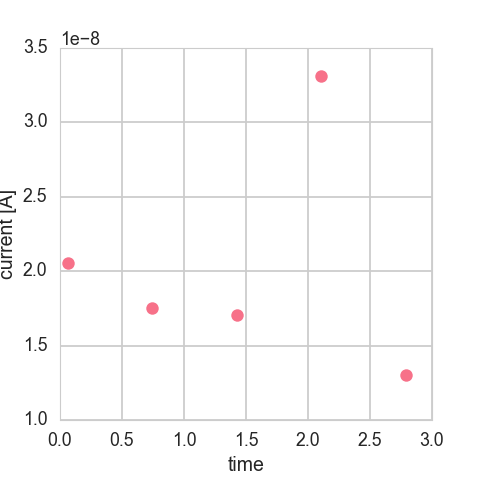

<IPython.core.display.Javascript object>


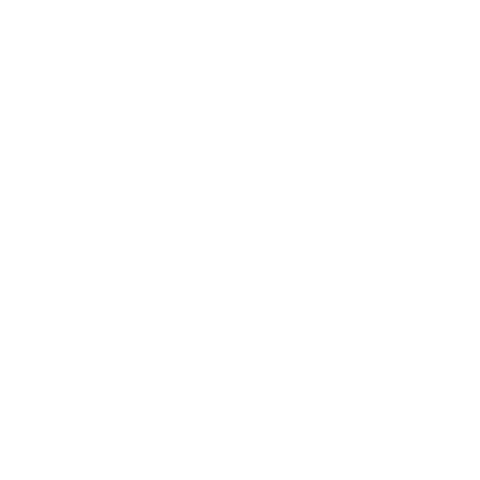

In [79]:

#関数化する！

"""These magics are required to do realtime show
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2
#%matplotlib nbagg
"""


import datetime

fig, ax = plt.subplots(figsize=(6,6))
plt.ion()

fig.show()
fig.canvas.draw()

time_list=[]
current_list=[]

inpt = my_instrument.write('*RST')
inpt = my_instrument.write(':SOUR:FUNC VOLT')
inpt = my_instrument.write(':SOUR:VOLT:MODE FIXED')
inpt = my_instrument.write(':SOUR:VOLT:RANG 20')
inpt = my_instrument.write(':SOUR:VOLT:LEV 10')
inpt = my_instrument.write(':SENS:CURR:PROT 10E-3')
inpt = my_instrument.write(':SENS:FUNC "CURR"')
inpt = my_instrument.write(':SENS:CURR:RANG 10E-3')
inpt = my_instrument.write(':FORM:ELEM CURR')
inpt = my_instrument.write(':OUTP ON')
now0 = datetime.datetime.now()

for cycle in range(5):
    ax.clear()
    now = datetime.datetime.now()
    elasped = (now - now0).total_seconds()
    output = my_instrument.query(':READ?')
    
    time_list.append(elasped)
    current_list.append(float(output))
    
    ax.plot(time_list, current_list, 'o')
    ax.set_xlabel('time')
    ax.set_ylabel('current [A]')
    fig.canvas.draw()
    
    time.sleep(.5)

inpt = my_instrument.write(':OUTP OFF')

#print time_list, current_list


In [73]:
import time
my_instrument = rm.open_resource('GPIB0::13::INSTR')
print(my_instrument.query("*IDN?"))

def v_sweep(curr_lev=0, sdel=1, cmpl=21, nplc=0.1, trg_cnt=5):
    """sweep V with constant current
    
    Args:
    v_start: float, start voltage [V]
    v_end: float, end voltage [V]
    v_step: float, voltage steps [V]
    sdel: float, source delay [s]
    cmpl: float, compliance current [A]
    nplc: integer, Number of Power Line cycles (integration time)
        nplc = 1 takes 16.67 (1/60) msec in theory
    
    Ret:
    output: pd.DataFrame with the columns of [voltage, , , , ]
    """

    
    ADD_time = 0.05 #emperical additional time for nplc
    sweep_time = (sdel + nplc * (0.01667 + ADD_time)) * trg_cnt
    
    print 'est. scan time = %d [s]' %sweep_time
    
    inpt = my_instrument.write('*RST') #reset
    inpt = my_instrument.write(':SOUR:CLE:AUTO ON') #set auto out-put off
    inpt = my_instrument.write(':SOUR:FUNC CURR')
    inpt = my_instrument.write(':SENS:FUNC \"VOLT\"') # sense Volt
    inpt = my_instrument.write(':SOUR:CURR:START 0') #set votage start
    inpt = my_instrument.write(':SOUR:CURR:STOP 0') #set voltage end
    inpt = my_instrument.write(':SOUR:CURR:STEP 0') #set voltage step
    inpt = my_instrument.write(':SOUR:VOLT:MODE SWE') #set sweep mode
 
    inpt = my_instrument.write(':SOUR:CURR:LEV ' + str(curr_lev))
    inpt = my_instrument.write(':SOUR:DEL ' + str(sdel)) #set source delay
    inpt = my_instrument.write(':SENS:VOLT:PROT ' + str(cmpl)) #set compliance
    inpt = my_instrument.write(':SENS:VOLT:NPLC ' + str(nplc)) #set compliance
    inpt = my_instrument.write(':TRIG:COUN ' + str(trg_cnt)) #set triger count = (start-end)/step + 1
    
    
    inpt = my_instrument.write(':INIT') #start sweep
    
    while True:
        time.sleep(1)
        opr = my_instrument.query(':STAT:OPER:EVEN?')
        reg = read_register(opr, 16)
        if reg[-11]=='1': #if "idle"(B11) is on 
            print 'scan completed'
            break
    
    buffer_out = my_instrument.query(':FETC?')

    return buffer_out

#t = v_sweep()



KEITHLEY INSTRUMENTS INC.,MODEL 2400,1386470,C32   Oct  4 2010 14:20:11/A02  /S/K



In [74]:
t = v_sweep(curr_lev=0, trg_cnt=100, sdel=.1)
out = conv_buffer2df(t, '','')
print out


est. scan time = 10 [s]
scan completed
     Voltage       Current    Registance      Time   Status
0   0.000107  3.943151e-11  9.910000e+37  57816.19  39940.0
1   0.000118  4.244290e-11  9.910000e+37  57816.30  39940.0
2   0.000121  4.545384e-11  9.910000e+37  57816.41  39940.0
3   0.000113  4.846543e-11  9.910000e+37  57816.52  39940.0
4   0.000105  4.194078e-11  9.910000e+37  57816.64  39940.0
5   0.000114  4.746104e-11  9.910000e+37  57816.75  39940.0
6   0.000110  4.595467e-11  9.910000e+37  57816.86  39940.0
7   0.000119  4.194017e-11  9.910000e+37  57816.97  39940.0
8   0.000116  4.796445e-11  9.910000e+37  57817.08  39940.0
9   0.000119  4.695906e-11  9.910000e+37  57817.19  39940.0
10  0.000117  4.695906e-11  9.910000e+37  57817.30  39940.0
11  0.000116  4.395005e-11  9.910000e+37  57817.41  39940.0
12  0.000117  4.043510e-11  9.910000e+37  57817.53  39940.0
13  0.000108  4.394893e-11  9.910000e+37  57817.64  39940.0
14  0.000116  4.947001e-11  9.910000e+37  57817.75  39940.0
1

In [110]:
print my_instrument.query(':STAT:OPER:EVEN?')

0



In [21]:
#JPN manual 18-46 about Data elements
#STATUS
binary = format(399490, 'b')
print binary, len(binary)

1100001100010000010 19


In [24]:
print format(65, 'b')

1000001


In [4]:
#JPN manual 15-5 register binary
def read_register(output, digit):
    out_enc = output.encode('utf-8')
    out_binary = str(format(int(out_enc), 'b'))
    out_string = out_binary.zfill(digit)
    return out_string

print read_register('64', 10)

0001000000


In [48]:
b = '0000010000000000'
print b[-11]

1
